## Setup and Imports

In [1]:
%pip install -qqqU pandas sqlalchemy psycopg2-binary wget requests pint

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import wget
import zipfile
import os
from datetime import datetime
import requests
import re
from pint import UnitRegistry

In [3]:
ureg = UnitRegistry()
ureg.define('tsp = teaspoon')
ureg.define('tbsp = tablespoon')
ureg.define('floz = fluid_ounce')
ureg.define('oz = ounce')

## Download Dataset

In [4]:
# Specify the date of the dataset
dataset_date = '2024-10-31'

skip_download = True # change this to refresh dataset.

if not skip_download:
    # URLs for the datasets
    base_url = 'https://fdc.nal.usda.gov/fdc-datasets'
    dataset_zip_url = f'{base_url}/FoodData_Central_csv_{dataset_date}.zip'
    
    # Download the zip file
    dataset_zip_path = wget.download(dataset_zip_url)
    
    # Extract the zip file
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall('fdc_data')

## Load to Pandas

In [5]:
# Define file paths
prefix = f'fdc_data/FoodData_Central_csv_{dataset_date}'
food_csv = f'{prefix}/food.csv'
nutrient_csv = f'{prefix}/nutrient.csv'
food_nutrient_csv = f'{prefix}/food_nutrient.csv'
measure_unit_csv = f'{prefix}/measure_unit.csv'
food_portion_csv = f'{prefix}/food_portion.csv'

# Load data
food_df = pd.read_csv(food_csv)
food_df = food_df[(food_df['data_type'] != "branded_food") & (food_df['data_type'] != "experimental_food")]

nutrient_df = pd.read_csv(nutrient_csv)
food_nutrient_df = pd.read_csv(food_nutrient_csv)
measure_unit_df = pd.read_csv(measure_unit_csv)
food_portion_df = pd.read_csv(food_portion_csv)

/var/folders/wc/l1mvr8fd1jlbk052krk77p0r0000gn/T/ipykernel_39838/1888289010.py:14: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  food_nutrient_df = pd.read_csv(food_nutrient_csv)


In [6]:
display(measure_unit_df)

,id,name
0,1000,cup
1,1001,tablespoon
2,1002,teaspoon
3,1003,liter
4,1004,milliliter
...,...,...
117,1117,bunch
118,1118,Tablespoons
119,1119,Banana
120,1120,Onion


In [7]:
# Nutrient IDs corresponding to required nutrients
nutrient_mapping = {
    'kcal': 1008,           # Energy (kcal)
    'fat': 1004,            # Total lipid (fat)
    'fat_sat': 1258,        # Fatty acids, total saturated
    'fat_trans': 1257,      # Fatty acids, total trans
    'fat_mono': 1292,       # Fatty acids, total monounsaturated
    'fat_poly': 1293,       # Fatty acids, total polyunsaturated
    'carbs': 1005,          # Carbohydrate, by difference
    'sugar': 2000,          # Sugars, total including NLEA
    'sugar_added': 1235,    # Sugars, added
    'fiber': 1079,          # Fiber, total dietary
    'protein': 1003,        # Protein
    'cholesterol': 1253,    # Cholesterol
    'sodium': 1093,         # Sodium, Na
    'caffeine': 1057,       # Caffeine
    'alcohol': 1018         # Alcohol, ethyl
}

# Filter food_nutrient_df for nutrients of interest
nutrients_of_interest = food_nutrient_df[food_nutrient_df['nutrient_id'].isin(nutrient_mapping.values())]

# Pivot the table to have nutrients as columns
nutrients_pivot = nutrients_of_interest.pivot_table(
    index='fdc_id',
    columns='nutrient_id',
    values='amount'
).reset_index()

# Map nutrient IDs to column names
nutrient_id_to_column = {v: k for k, v in nutrient_mapping.items()}
nutrients_pivot.rename(columns=nutrient_id_to_column, inplace=True)

In [8]:
# Merge nutrients with food descriptions
merged_data = pd.merge(
    food_df[['fdc_id', 'description', 'data_type']],
    nutrients_pivot,
    on='fdc_id',
    how='left'
)
original_count = merged_data.shape[0]
merged_data.dropna(subset=['protein', 'fat', 'carbs', 'kcal'], how='all', inplace=True)

print(f'Dropped {original_count - merged_data.shape[0]} rows with no macro and calorie info.')

Dropped 64381 rows with no macro and calorie info.


In [9]:
display(merged_data.head())

,fdc_id,description,data_type,protein,fat,carbs,kcal,alcohol,caffiene,fiber,sodium,sugar_added,cholesterol,fat_trans,fat_sat,fat_mono,fat_poly,sugar
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",sr_legacy_food,5.88,13.24,41.18,307.0,NaN,NaN,1.2,1059.0,NaN,0.0,4.412,2.941,NaN,NaN,5.88
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",sr_legacy_food,4.34,11.27,53.42,330.0,NaN,NaN,1.4,780.0,NaN,0.0,4.290,3.250,NaN,NaN,21.34
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",sr_legacy_food,6.10,3.70,79.80,377.0,NaN,NaN,NaN,2182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,167515,"George Weston Bakeries, Thomas English Muffins",sr_legacy_food,8.00,1.80,46.00,232.0,NaN,NaN,NaN,345.0,NaN,NaN,0.082,0.308,0.303,0.920,NaN
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",sr_legacy_food,6.58,9.22,41.05,273.0,0.0,0.0,2.2,621.0,NaN,15.0,NaN,1.898,4.530,1.445,4.30


In [10]:
merged_data.shape

(17735, 18)

In [11]:
food_portion_df.head()

,id,fdc_id,seq_num,amount,measure_unit_id,portion_description,modifier,gram_weight,data_points,footnote,min_year_acquired
0,81549,167512,1.0,1.0,9999,NaN,serving,34.0,NaN,NaN,NaN
1,81550,167513,1.0,1.0,9999,NaN,serving 1 roll with icing,44.0,1.0,NaN,NaN
2,81551,167514,1.0,1.0,9999,NaN,serving,28.0,NaN,NaN,NaN
3,81552,167515,1.0,1.0,9999,NaN,serving,57.0,NaN,NaN,NaN
4,81553,167516,1.0,1.0,9999,NaN,"waffle, square",39.0,10.0,NaN,NaN


In [12]:
food_portion_merged_df = pd.merge(
    food_portion_df,
    measure_unit_df,
    left_on='measure_unit_id',
    right_on='id',
    how='left'
)

cols_desired = ['id_x', 'fdc_id', 'amount', 'modifier', 'name', 'portion_description', 'gram_weight']
food_portion_merged_df = food_portion_merged_df[cols_desired]

food_portion_merged_df.rename({ 'id_x': 'portion_id', 'name': 'unit_name' }, axis=1, inplace=True)
food_portion_merged_df.set_index('portion_id')

food_portion_merged_df.replace('undetermined', np.nan, inplace=True)

food_portion_merged_df.dropna(subset=['gram_weight'], inplace=True)
food_portion_merged_df.dropna(subset=['amount', 'modifier', 'unit_name'], how='all', inplace=True)

In [13]:
# display(food_portion_merged_df.sample(10))
display(food_portion_merged_df[pd.notna(food_portion_merged_df['unit_name'])].sample(10))
# display(food_portion_merged_df[food_portion_merged_df['unit_name'] == 'cup'].sample(100))

,portion_id,fdc_id,amount,modifier,unit_name,portion_description,gram_weight
20535,190334,747977,1.0,yolk,egg,NaN,16.0
15815,120079,330978,1.0,without skin,drumstick,NaN,139.0
16052,120316,331069,1.0,with skin,drumstick,NaN,77.0
23040,192839,748714,1.0,white,egg,NaN,33.1
15241,119505,326905,1.0,NaN,each,NaN,8.4
19459,189258,747861,1.0,white,egg,NaN,33.2
20354,190153,747952,1.0,white,egg,NaN,32.7
22704,192503,748629,1.0,whole without shell,egg,NaN,50.0
18155,187954,747740,1.0,yolk,egg,NaN,15.5
17231,121495,332876,1.0,NaN,cookie,NaN,31.2


In [14]:
volume_units = ['milliliter', 'liter', 'fluid_ounce', 'cup', 'pint', 'quart', 'gallon', 'teaspoon', 'tablespoon']

In [15]:
def calculate_row_density(row):
    gram_weight = row['gram_weight']
    
    # Initialize variables
    amount = None
    unit = None
    
    # Combine 'amount', 'modifier', and 'portion_description' into a single text
    text_components = []
    if pd.notna(row['amount']) and (pd.notna(row['modifier']) or pd.notna(row['unit_name'])):
        text_components.append(str(row['amount']))

        modifier = row['modifier'] if pd.notna(row['modifier']) else row['unit_name']
        text_components.append(str(modifier))
        
    elif pd.notna(row['portion_description']):
        text_components.append(str(row['portion_description']))
        
    else:
        return np.nan
    
    text = ' '.join(text_components).lower()

    # Use regex to extract amount and unit
    # Pattern matches: [number][optional spaces][unit]
    match = re.search(r'(\d*\.?\d+)\s*(?:\(?\s*([\w\s\/]+)\s*\)?)', text)
    if match:
        amount_str = match.group(1)
        unit_str = match.group(2)
        if amount_str and unit_str:
            try:
                amount = float(amount_str)
                unit = unit_str.strip().lower()
            except ValueError:
                return np.nan
    else:
        # Cannot parse amount and unit
        return np.nan
    
    # Normalize unit names
    unit_aliases = {
        'g': 'gram',
        'grams': 'gram',
        'mg': 'milligram',
        'kg': 'kilogram',
        'ounce': 'ounce',
        'ounces': 'ounce',
        'oz': 'ounce',
        'lb': 'pound',
        'pound': 'pound',
        'fl oz': 'fluid_ounce',
        'fluid ounce': 'fluid_ounce',
        'fluid ounces': 'fluid_ounce',
        'fluid_ounce': 'fluid_ounce',
        'cup': 'cup',
        'cups': 'cup',
        'pint': 'pint',
        'pints': 'pint',
        'quart': 'quart',
        'quarts': 'quart',
        'gallon': 'gallon',
        'gallons': 'gallon',
        'tsp': 'teaspoon',
        'teaspoon': 'teaspoon',
        'teaspoons': 'teaspoon',
        'tbsp': 'tablespoon',
        'tablespoon': 'tablespoon',
        'tablespoons': 'tablespoon',
        'ml': 'milliliter',
        'milliliter': 'milliliter',
        'milliliters': 'milliliter',
        'l': 'liter',
        'liter': 'liter',
        'liters': 'liter',
        # TODO: add cubic inc
    }
    # Handle units with '/' or multiple words, e.g., 'cups chopped'
    unit_tokens = unit.replace('fl oz', 'fluid_ounce').replace('fluid ounce', 'fluid_ounce').split(' ')
    unit_main = unit_tokens[0]
    unit_normalized = unit_aliases.get(unit_main, None)
    
    if not unit_normalized:
        return np.nan
    
    # Check if the unit is a volume unit

    # Need a volume unit to calcualte density
    if unit_normalized not in volume_units:
        return np.nan
    
    # Try converting amount and unit to milliliters, return nan if it fails.
    try:
        volume_ml = (amount * ureg(unit_normalized)).to('milliliter').magnitude
    except Exception as e:
        return np.nan 

    # We can't calculate the volume if we have 0 denominator.
    if volume_ml == 0:
        return np.nan 
    
    # Calculate density (grams per milliliter)
    density = gram_weight / volume_ml
    return density

In [16]:
# Apply the function to calculate density for each row
food_portion_merged_df['density'] = food_portion_merged_df.apply(calculate_row_density, axis=1)

In [17]:
food_portion_merged_df['density'].shape

(47173,)

In [18]:
food_portion_merged_df['density'].isna().sum() / food_portion_merged_df['density'].shape[0]

np.float64(0.7842621838763699)

In [19]:
average_density_df = food_portion_merged_df.groupby('fdc_id', dropna=True)['density'].median()

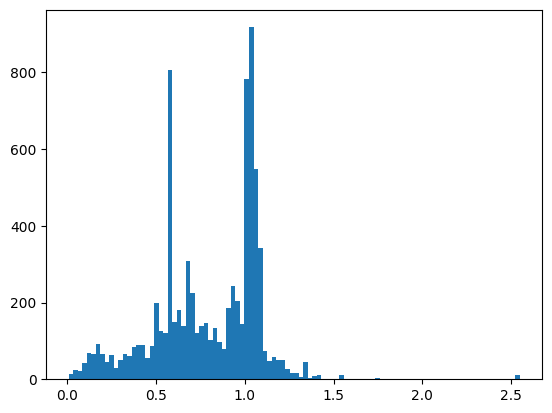

In [20]:
import matplotlib.pyplot as plt

plt.hist(average_density_df, bins=100)
plt.show()

In [21]:
final_df = pd.merge(merged_data, average_density_df, on='fdc_id', how='left')
final_df.set_index('fdc_id', inplace=True)

In [22]:
final_df.shape

(17735, 18)

In [23]:
display(final_df[pd.notna(final_df['density'])].sample(10))

,description,data_type,protein,fat,carbs,kcal,alcohol,caffiene,fiber,sodium,sugar_added,cholesterol,fat_trans,fat_sat,fat_mono,fat_poly,sugar,density
fdc_id,,,,,,,,,,,,,,,,,,
2709528,"Potato, baked, peel eaten, with meat",survey_fndds_food,4.74,8.28,17.09,160.0,0.0,0.0,1.7,257.0,NaN,24.0,NaN,4.487,1.908,0.436,1.24,0.676280
168809,"Ice creams, chocolate",sr_legacy_food,3.80,11.00,28.20,216.0,0.0,3.0,1.2,76.0,NaN,34.0,NaN,6.800,3.210,0.410,25.36,0.557931
2706345,"Crab, canned",survey_fndds_food,17.88,0.74,0.00,83.0,0.0,0.0,0.0,563.0,NaN,97.0,NaN,0.201,0.129,0.258,0.00,0.570612
167699,"Salad dressing, blue or roquefort cheese dress...",sr_legacy_food,1.52,1.01,25.60,115.0,0.0,0.0,1.8,814.0,NaN,2.0,0.096,0.450,0.441,0.069,7.44,1.134883
175244,"Beans, kidney, royal red, mature seeds, cooked...",sr_legacy_food,9.49,0.17,21.85,123.0,NaN,NaN,9.3,241.0,NaN,0.0,0.000,0.024,0.013,0.093,NaN,0.748135
169574,"Alcoholic beverage, daiquiri, prepared-from-re...",sr_legacy_food,0.06,0.06,6.94,186.0,23.1,0.0,0.1,5.0,NaN,0.0,0.000,0.006,0.006,0.016,5.58,1.021183
2706372,"Guisada, beef",survey_fndds_food,10.85,6.62,2.52,115.0,0.0,0.0,0.5,305.0,NaN,36.0,NaN,2.550,2.927,0.237,0.63,1.077822
170964,"Babyfood, cereal, mixed, dry fortified",sr_legacy_food,6.66,6.66,78.21,399.0,0.0,0.0,6.7,33.0,NaN,0.0,NaN,0.769,1.206,1.697,26.66,0.169070
170965,"Babyfood, cereal, mixed, with bananas, dry",sr_legacy_food,10.70,4.60,77.10,391.0,0.0,0.0,7.8,0.0,NaN,0.0,NaN,0.846,1.223,1.734,6.68,0.169070


In [24]:
final_df['data_type'].value_counts()

data_type
sr_legacy_food              7793
survey_fndds_food           5431
sub_sample_food             3324
agricultural_acquisition     810
foundation_food              377
Name: count, dtype: int64

## Testing it out

In [25]:
def calculate_coefficient (df: pd.DataFrame, quantity_ate: any, unit_ate: any, base_weight: int = 100) -> float:
    # we need to figure out if we have volume or mass.
    unit_type = "volume" if unit_ate in volume_units else "mass"
    
    coeff = np.nan
    
    if unit_type == 'volume':
        # if we have volume, we need to check density.
        d = row['density']
    
        # check if nan or null
        if not d or d == np.nan:
            print('can\'t calculate, no volume')
            return coeff
    
        # if we have density, it's g/mL
        # convert the volume we ate into mL
        vol = ureg.Quantity(quantity_ate, unit_ate)
        vol_ml = vol.to('ml')
    
        # to figure out how many grams we ate, 
        # d = mass/volume
        # therefore mass = density * vol
        # multiply the volume we ate by the density
        mass_g = d * vol_ml
    
        coeff = mass_g / 100

        return coeff
    
    elif unit_type == 'mass':
        # Convert to grams.
        mass = ureg.Quantity(quantity_ate, unit_ate)
        mass_g = mass.to('grams')
    
        coeff = mass_g / 100.0

        return coeff

In [26]:
food_name = "Milk, nonfat, fluid"
identified_food = 746776 # Milk
quantity_ate = 1 # grams
unit_ate = 'cup'

row = final_df.loc[identified_food]
macros_of_interest = ['kcal', 'protein', 'fat', 'carbs']
coeff = calculate_coefficient(row, quantity_ate, unit_ate)

# we need to determine if we have a weight or volume unit. 
nutrition_df = pd.DataFrame(row[macros_of_interest] * coeff).T

print(f"""{food_name} ({quantity_ate} {unit_ate}):
------
{nutrition_df['kcal'][identified_food]} cal
Fats: {nutrition_df['fat'][identified_food]}g
Carb: {nutrition_df['carbs'][identified_food]}g
Prot: {nutrition_df['protein'][identified_food]}g
""")

Milk, nonfat, fluid (1 cup):
------
83.64 cal
Fats: 0.1968g
Carb: 12.1032g
Prot: 8.437800000000001g



/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/pandas/core/construction.py:630: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [27]:
food_name = "Moo Goo Gai Pan"
identified_food = 2706795 # Moo Goo Gai Pan
quantity_ate = 2.5 # grams
unit_ate = 'cup'

row = final_df.loc[identified_food]
macros_of_interest = ['kcal', 'protein', 'fat', 'carbs']
coeff = calculate_coefficient(row, quantity_ate, unit_ate)

# we need to determine if we have a weight or volume unit. 
nutrition_df = pd.DataFrame(row[macros_of_interest] * coeff).T

print(f"""{food_name} ({quantity_ate} {unit_ate}):
------
{nutrition_df['kcal'][identified_food]} cal
Fats: {nutrition_df['fat'][identified_food]}g
Carb: {nutrition_df['carbs'][identified_food]}g
Prot: {nutrition_df['protein'][identified_food]}g
""")

Moo Goo Gai Pan (2.5 cup):
------
372.6 cal
Fats: 13.176g
Carb: 26.298000000000002g
Prot: 38.394000000000005g



/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/pandas/core/construction.py:630: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


## Write to CSV

In [32]:
# Prepare for Supabase
final_df.rename({
    'description': 'name'
}, inplace=True, axis=1)

In [33]:
final_df.to_csv('usda_foods.csv')

In [29]:
final_df.columns

Index(['description', 'data_type', 'protein', 'fat', 'carbs', 'kcal',
       'alcohol', 'caffiene', 'fiber', 'sodium', 'sugar_added', 'cholesterol',
       'fat_trans', 'fat_sat', 'fat_mono', 'fat_poly', 'sugar', 'density'],
      dtype='object')